# Form Recognition in Spark-OCR fine-tuning

Set license and AWS keys

In [ ]:
## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [ ]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12/"

import os
if license:
    os.environ['JSL_OCR_LICENSE'] = license

## Install deps 

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
# downloading and unzipping the dataset
!rm -r ./llmv2_Alab_data
!gdown --id 1QqR19Wa2VCklL69WZOFkwZyeeo5yjyQx
!unzip "DS.zip" -d ./llmv2_Alab_data

# Separating the inference image
!mkdir test
!mv ./llmv2_Alab_data/images/63-1651494444_0.png ./test/63-1651494444_0.png

In [ ]:
# Installing Dependencies
! python3.7 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
! python3.7 -m pip install datasets==1.18.2

! python3.7 -m pip uninstall numpy -y
! python3.7 -m pip install transformers==4.16.2

## Start Spark session with Spark OCR

In [ ]:
license = ""

import os
os.environ['JSL_OCR_LICENSE'] = license

from sparkocr import start
from pyspark import SparkConf

spark_ocr_jar_path = "../../../target/scala-2.12/"
spark = start(jar_path = spark_ocr_jar_path)

# (only required for colab in some weird situations)
# spark._jvm.System.loadLibrary("opencv_java320")

# !find / -name *opencv_java*
# !ln -s /usr/lib/jni/libopencv_java320.so /usr/lib/jni/libopencv_java.so

Spark version: 3.0.2
Spark NLP version: 3.4.4
Spark OCR version: 3.12.1rc3



## Read image with form

In [3]:
%%time
from sparkocr.transformers.readers.alab_readers import AlabReaders

pyspark_dataframe = AlabReaders().dataLabeler(spark,
                                              "./llmv2_Alab_data/result.json",
                                              "./llmv2_Alab_data/images"
                                              ).cache()


12:06:45, INFO NumExpr defaulting to 4 threads.


CPU times: user 1.52 s, sys: 214 ms, total: 1.73 s
Wall time: 5.23 s


## Define pipeline for predict

In [4]:
from pyspark.ml import PipelineModel
from sparkocr.enums import *
from sparkocr.transformers import *
from sparkocr.transformers.ner import *
from sparkocr.transformers.tokenizer.hocr_tokenizer import HocrTokenizer
from sparkocr.utils import display_images_horizontal


binary_to_image = BinaryToImage() \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token")


## Prepare train dataset (using predict results as training data)

In [5]:
import gc
gc.collect()

224

## Define VisualDocumentNerV21 for finetuning

* load model
* difine params of training

In [6]:
doc_ner_fine_tuned = VisualDocumentNerV21()\
            .loadHugingFaceModel("nielsr/layoutlmv2-finetuned-funsd", spark) \
            .setInputCols(["token", "image"]) \
            .setOutputCol("entities") \
            .setWhiteList( ['Diagnosis-B',
                            'Diagnosis-I',
                            'Drug-B',
                            'Drug-I',
                            'Symptom-B',
                            'Symptom-I',
                            'others'])\
            .setLabels(['Diagnosis-B',
                            'Diagnosis-I',
                            'Drug-B',
                            'Drug-I',
                            'Symptom-B',
                            'Symptom-I',
                            'others'])\
            .setbatchSize(4) \
            .setShuffleBatchTraining(True) \
            .setnumTrainEpochs(15)\
            .setImageSize(224)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/765M [00:00<?, ?B/s]

### Pre-Training Inference

In [7]:
draw_annotations = ImageDrawAnnotations() \
            .setInputCol("image") \
            .setInputChunksCol("entities") \
            .setOutputCol("image_with_annotations") \
            .setFilledRect(False) \
            .setFontSize(14) \
            .setRectColor(Color.red) #\
            # .setColorMap(
            # {"other": Color.pink, "b-header": Color.yellow, "i-header": Color.yellow, "b-question": Color.blue,
            #  "i-question": Color.blue, "b-answer": Color.green, "i-answer": Color.green})

pipeline_predict = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner_fine_tuned,
    draw_annotations
])


    Image #0:
    Origin: file:/content/test/63-1651494444_0.png
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


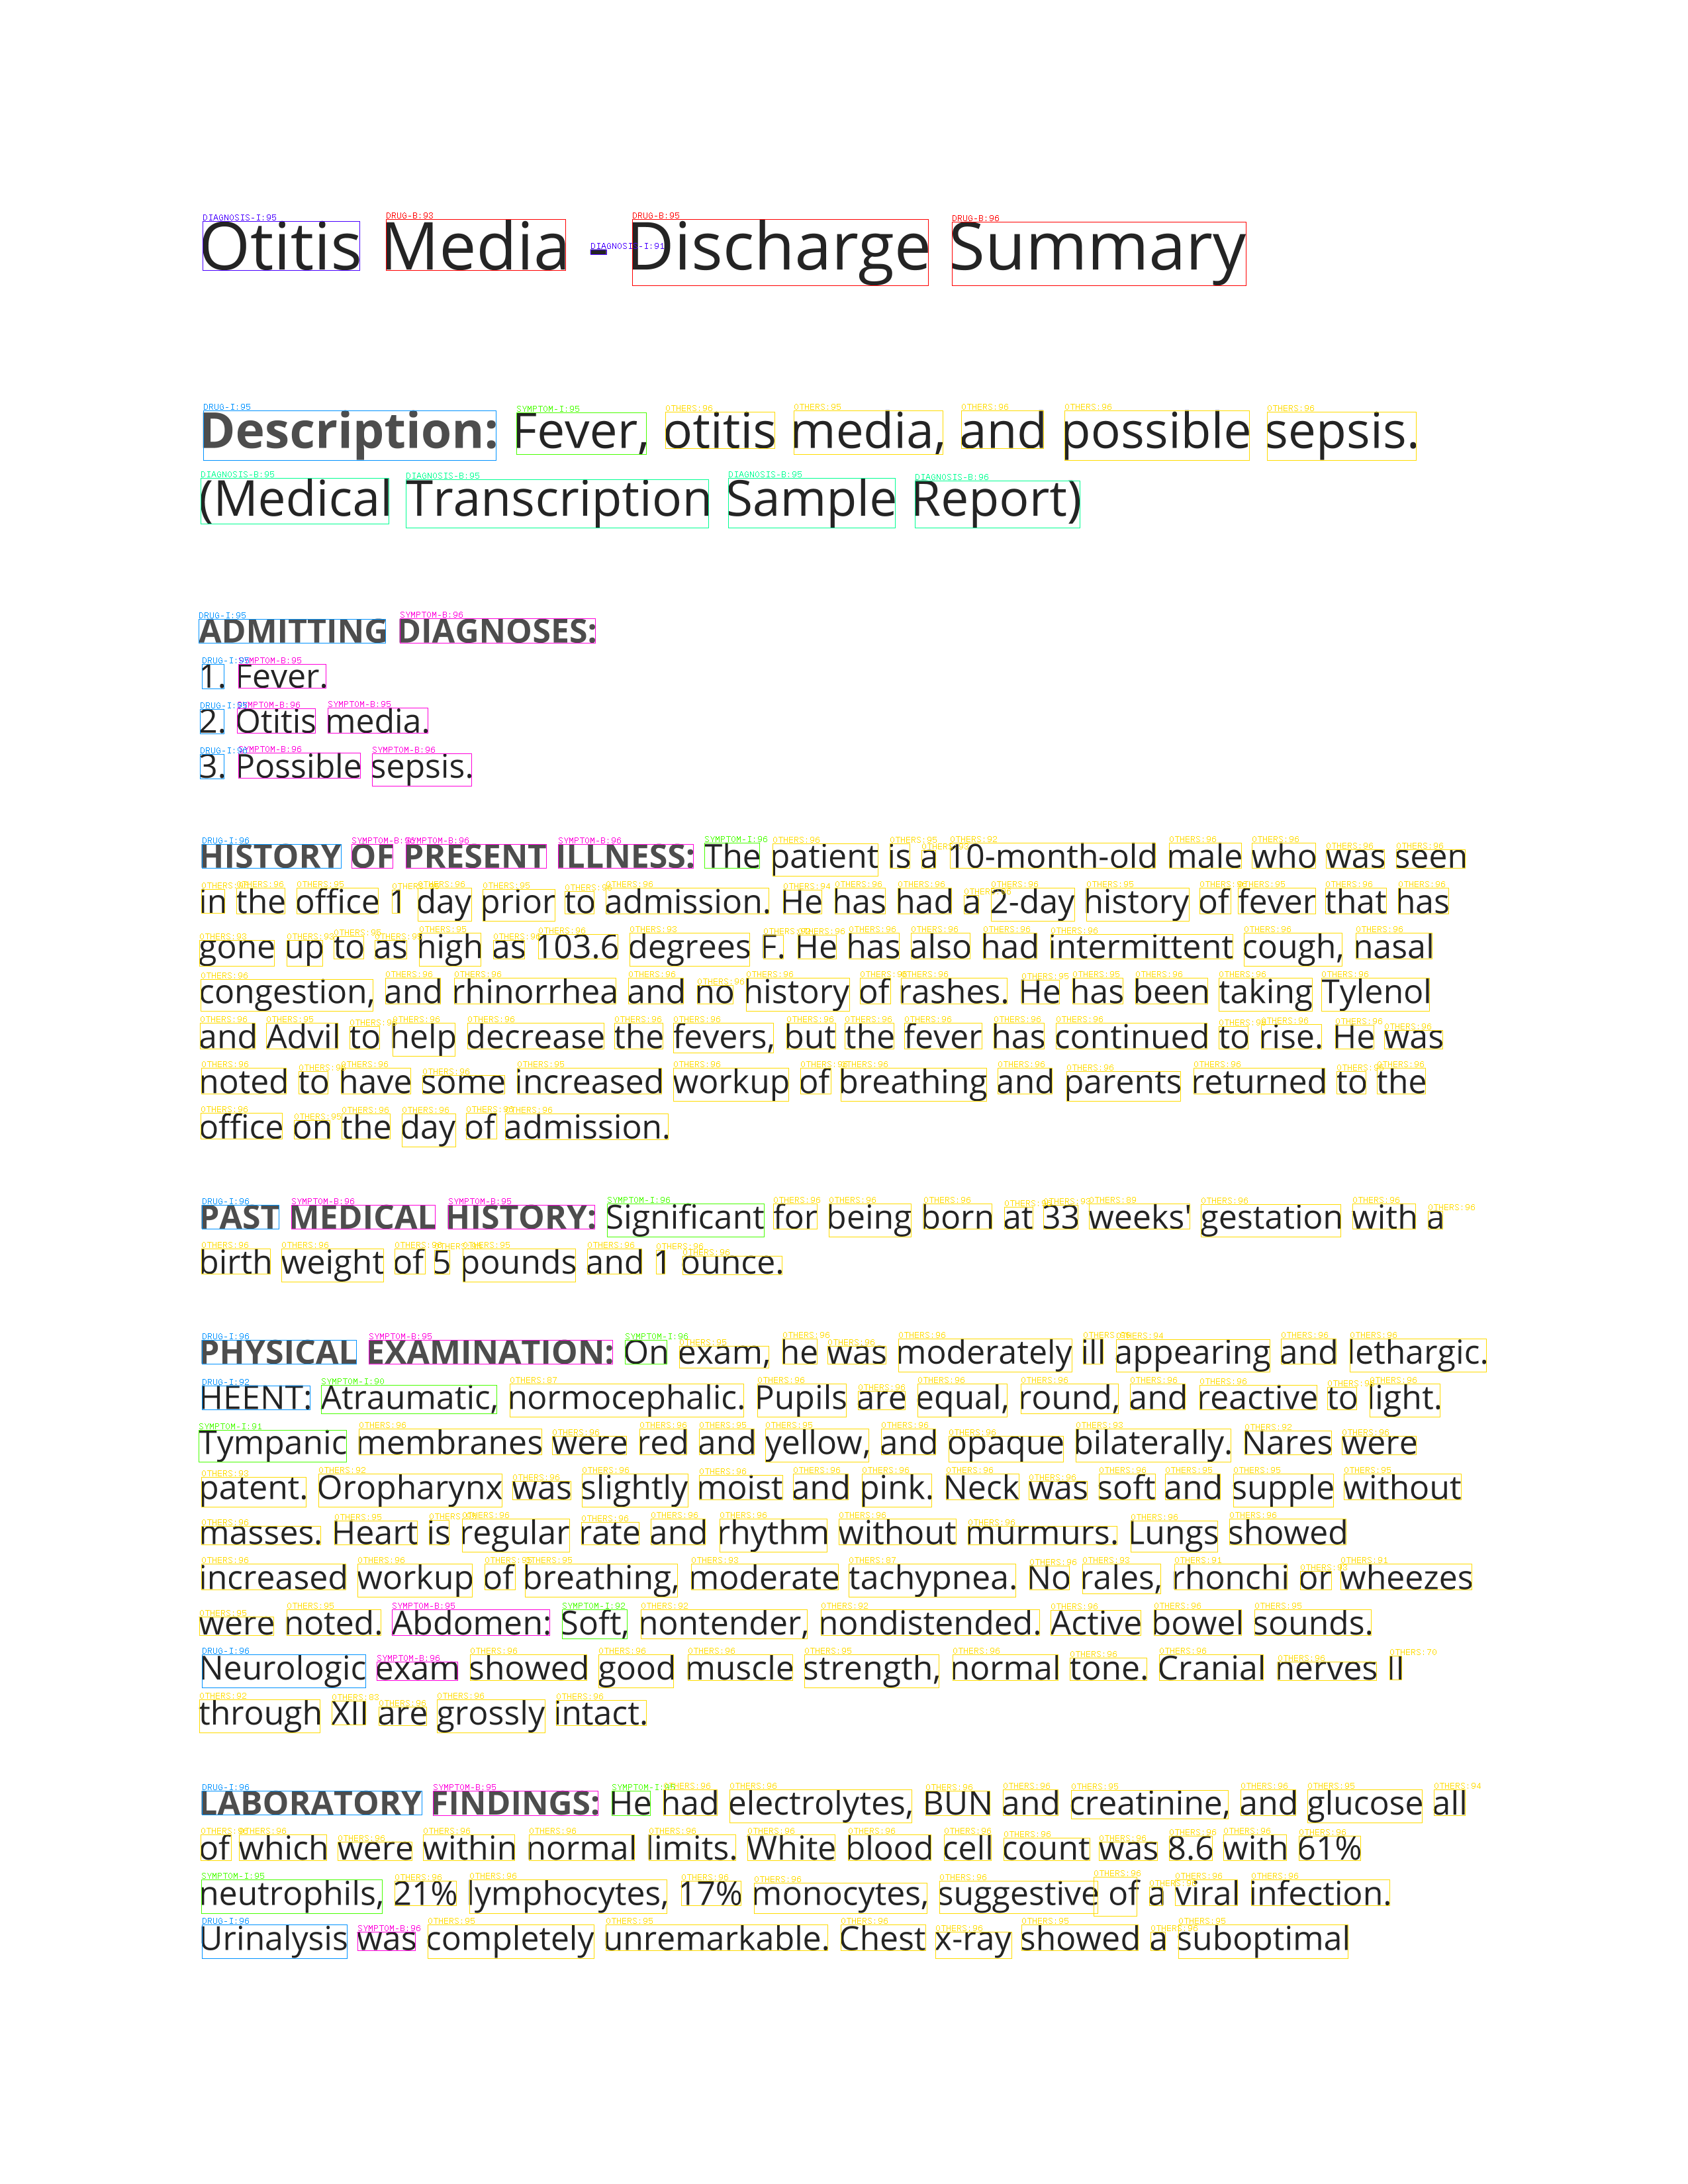

In [8]:
from sparkocr.utils import display_images_horizontal

from sparkocr.utils import display_images

  
bin_df = spark.read.format("binaryFile").load("./test")
results = pipeline_predict.transform(bin_df)

display_images(results, "image_with_annotations")


## Fit the model

In [9]:
%%time
ner_fit_model = doc_ner_fine_tuned.fit(pyspark_dataframe)


12:08:52, INFO Preparing Training Data.


  0%|          | 0/1 [00:00<?, ?ba/s]

12:18:43, INFO Pytorch model Training.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
12:18:43, INFO Training Started.
  0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layou

CPU times: user 7min 20s, sys: 2min 19s, total: 9min 40s
Wall time: 19min 8s


## Call finetuned model for predict

In [10]:
pipeline_predict = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    ner_fit_model,
    draw_annotations
])

### Post Training Inference


    Image #0:
    Origin: file:/content/test/63-1651494444_0.png
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


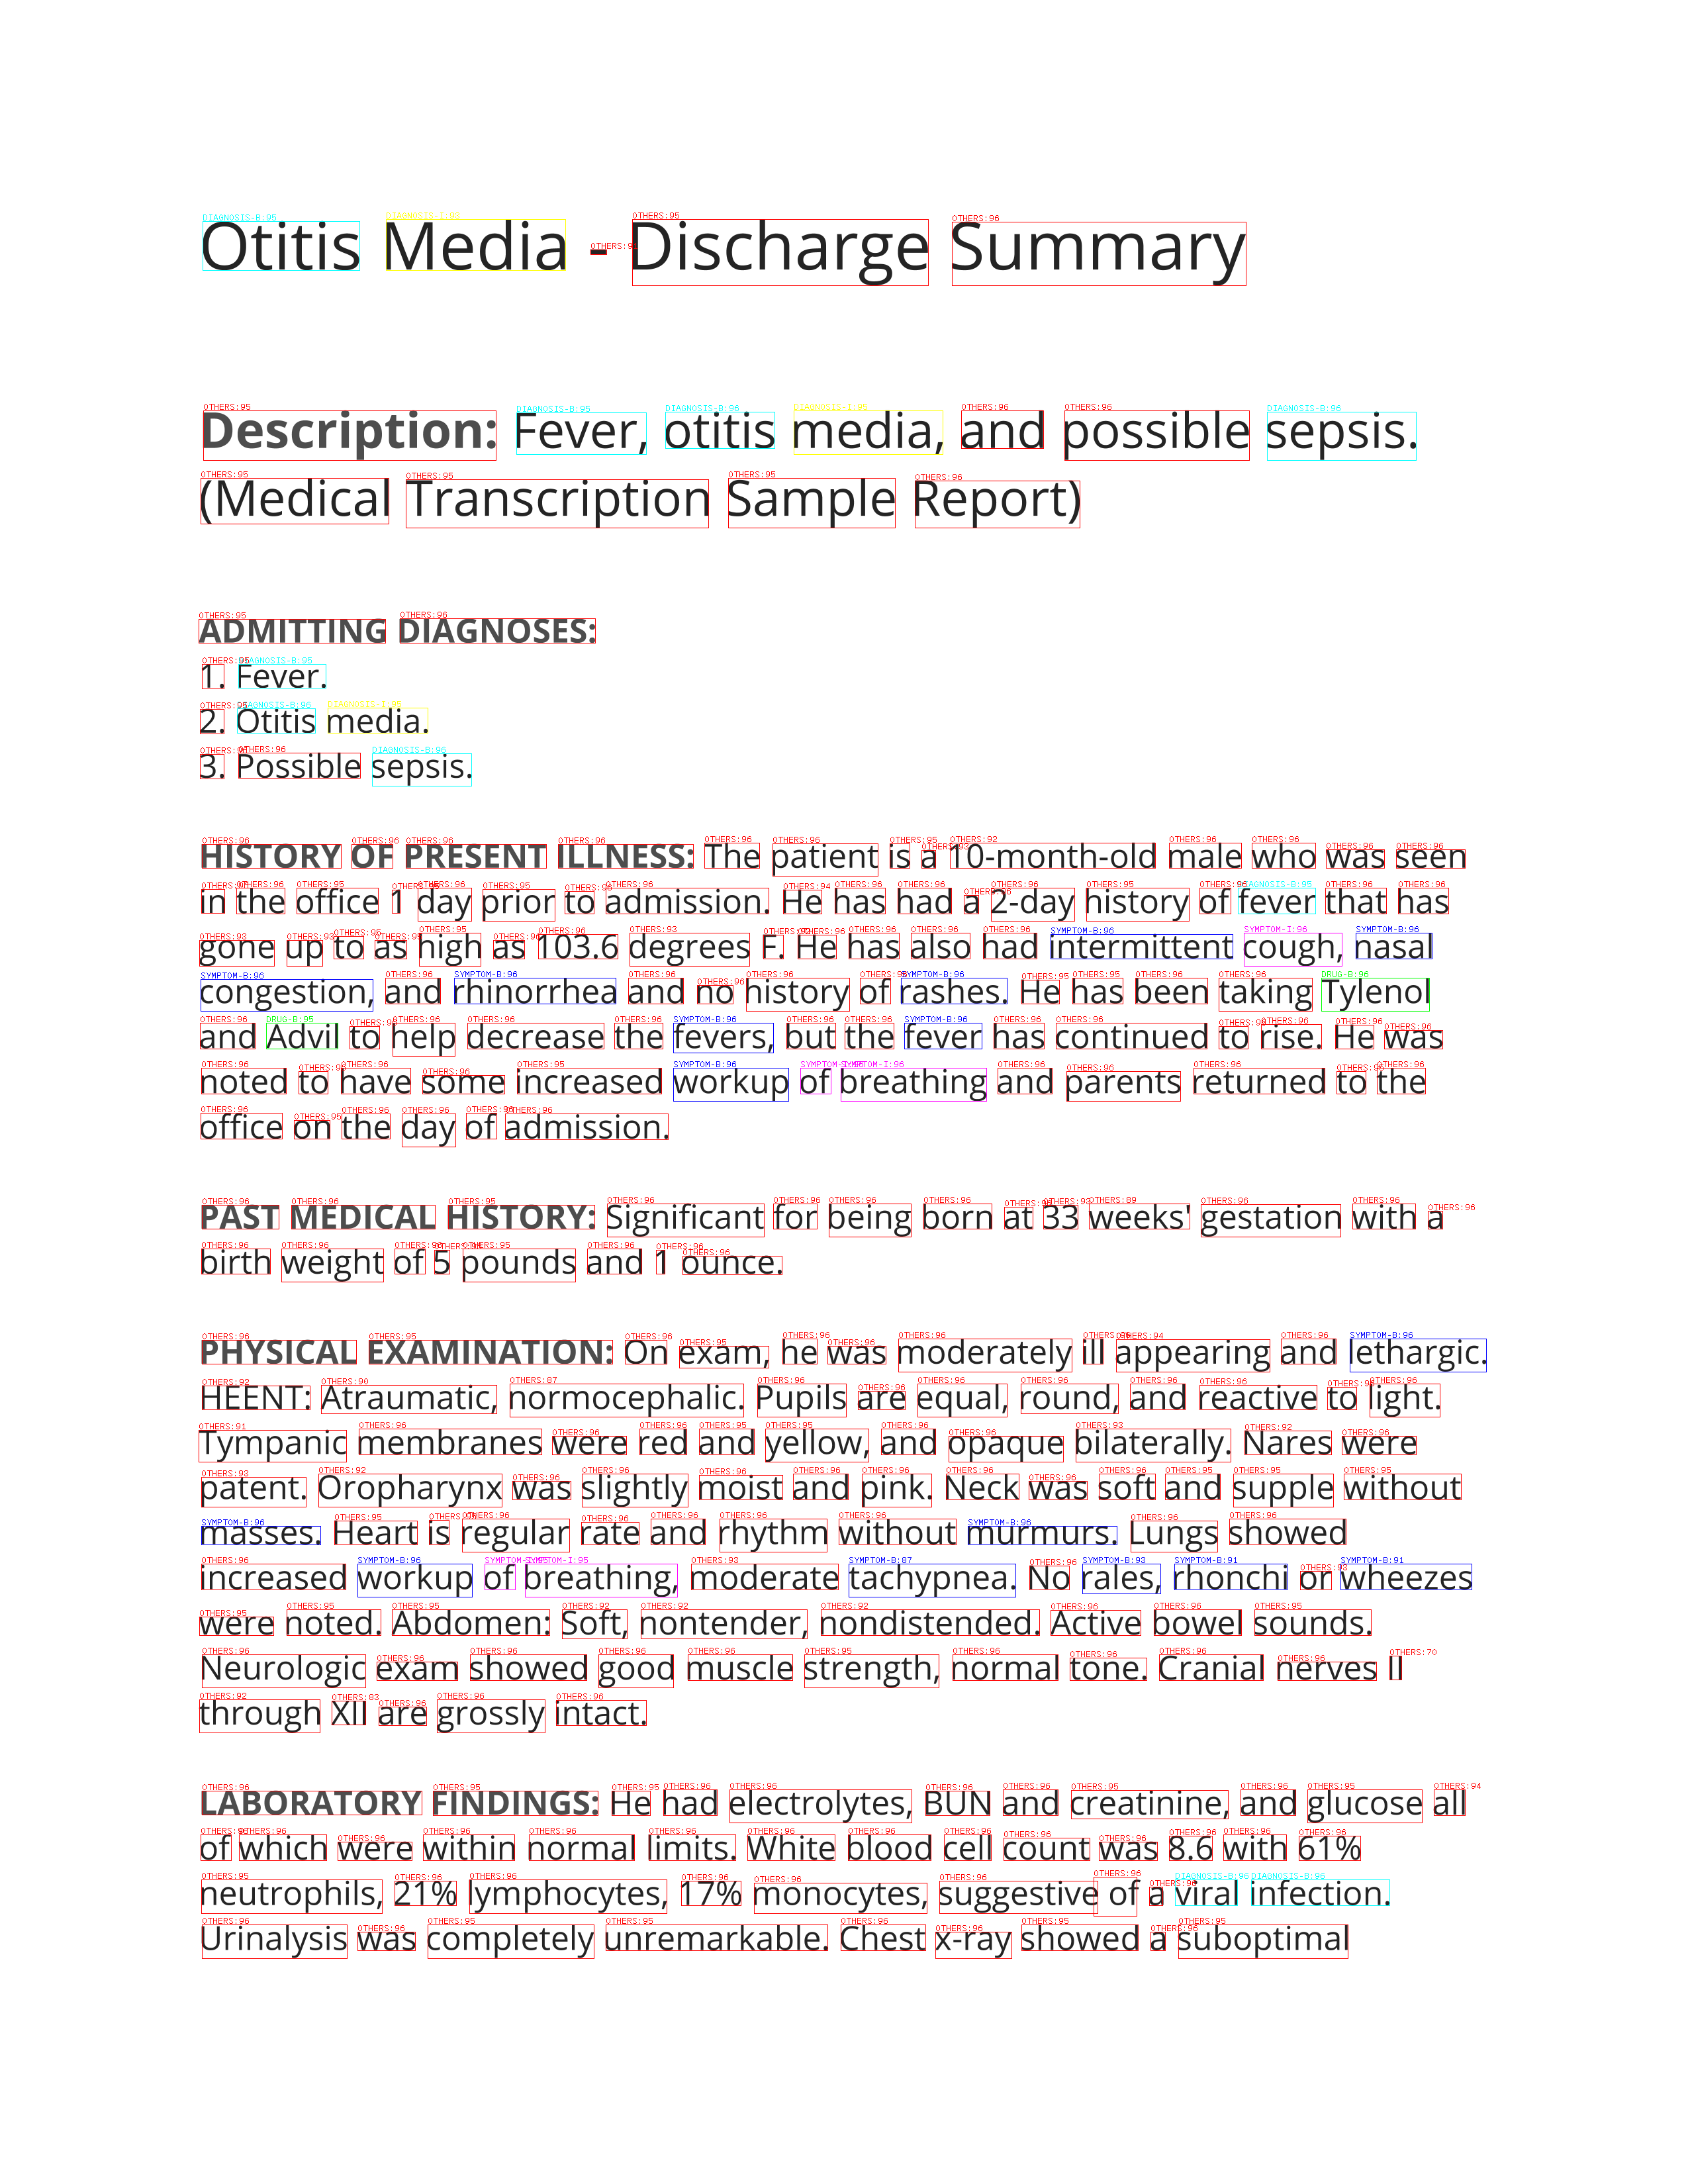

In [11]:
from sparkocr.utils import display_images_horizontal

from sparkocr.utils import display_images

  
bin_df = spark.read.format("binaryFile").load("/content/test")
bin_df = bin_df
results = pipeline_predict.transform(bin_df)

display_images(results, "image_with_annotations")
